<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020_private/blob/main/cwiczenia_1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Przykład z wykładu prof. Broniowskiego**
Inżynieria danych 2019/20
Wersja z 18.04.2020

# Sieć neuronowa

# Importowane pakiety

In [ ]:
import math  as m
import numpy as np

# liczby losowe
import random

# grafika do wykresów
import matplotlib.pyplot as plt
import matplotlib as mpl

# działania na łańcuchach znaków
import string 

# statystyka
import statistics as st

# pomar czasu
import time

# dopasowywanie krzywych do danych
from scipy.optimize import curve_fit

# wyświetlanie importowanej grafiki
from IPython.display import display, Image

# wykresy konturowe
import matplotlib.cm as cm

# Funkcje rysujące sieć neuronową

In [ ]:
def plot_net(n_war):
    """Narysuj szkielet sieci"""
    li_war=len(n_war)
    plt.figure(figsize=(7,4)) # rozmiar rysunku

    for i in range(li_war): # pętla po warstwach
        for j in range(1,n_war[i]): # pętla po węzłach innych niż progowe w warstwie (zaczynamy od 1)
            plt.scatter(i, j-n_war[i]/2, s=100,c='blue') 
            # rysuj punkt o współrzędnej poziomej i oraz współrzędnej pionowej rosnącej z j 
            # odjęcie n_war[i]/2 powoduje, że średnie pionowe połozenie punktów jest 0
        
    for i in range(li_war-1): # pętla po warstwach z wyjatkiem outputowej
            plt.scatter(i, 0-n_war[i]/2, s=100,c='gray') # dodaj węzły progowe innym kolorem
    
    for i in range(li_war-1): # pętla po warstwach z wyjątkim ostatniej
        for j in range(n_war[i]): # pętla po węzłach, z których wychodzi krawędź
            for k in range(n_war[i+1]-1):  # pętla po węzłach z kolejnej wartwy, do których wchodzi krawędź
                plt.plot([i,i+1],[j-n_war[i]/2,k+1-n_war[i+1]/2],c='gray') # rysowanie krawędzi
                # współrzędne odpowiadają współrzędnym punktu

    plt.title("Sieć o inpucie i " + str(li_war-1)+" warstwach",fontsize=16)

    plt.axis("off")
    plt.show()

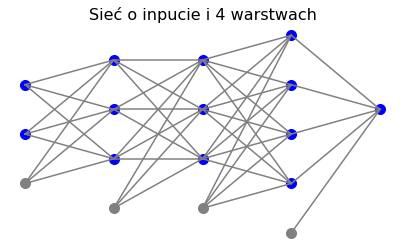

In [ ]:
plot_net([3,4,4,5,2])

In [ ]:
def plot_net_w(n_war, wagi):
    """Narysuj sieć z wagami"""
    li_war=len(n_war)
    plt.figure(figsize=(7,4)) # rozmiar rysunku

    for i in range(li_war): # pętla po warstwach
        for j in range(1,n_war[i]): # pętla po węzłach innych niż progowe w warstwie (zaczynamy od 1)
            plt.scatter(i, j-n_war[i]/2, s=100,c='blue') 
            # rysuj punkt o współrzędnej poziomej i oraz współrzędnej pionowej rosnącej z j 
            # odjęcie n_war[i]/2 powoduje, że średnie pionowe połozenie punktów jest 0
        
    for i in range(li_war-1): # pętla po warstwach z wyjatkiem outputowej
            plt.scatter(i, 0-n_war[i]/2, s=100,c='gray') # dodaj węzły progowe innym kolorem
    
    li_par=0 #liczba wag
    
    for i in range(li_war-1):
        for j in range(n_war[i]):
            for k in range(n_war[i+1]-1):
                li_par+=1
                th=3*wagi[i+1][j][k]
                if th>0:
                    col='red'
                else:
                    col='blue'
                th=abs(th)
                plt.plot([i,i+1],[j-n_war[i]/2,k+1-n_war[i+1]/2],c=col,linewidth=th)
                

    plt.title("Sieć o inpucie i "+str(li_war-1)+" warstwach (liczba wag: "+str(li_par)+")",fontsize=16)

    plt.axis("off")
    plt.show()

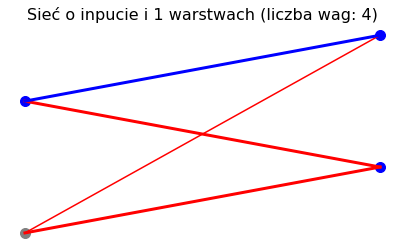

In [ ]:
plot_net_w([2,3],{1:[[1,.5],[1,-1]]})

### Inicjalizowanie losowe wag

In [ ]:
# skrót dla generowania liczby losowej w przedziale (-0.5,0.5)
def rn():
    return random.random()-0.5

In [ ]:
# losowe wagi z przedziału (-0.5,0.5)
def ran_w(n_war):
    li_war=len(n_war) 
    wa={}
    for k in range(len(n_war)-1):
        wa.update({k+1: [[rn() for i in range(n_war[k+1]-1)] for j in range(n_war[k])]})
    return wa

In [ ]:
# losowe wagi z przedziału (-0.5s,0.5s)
def ran_w_s(n_war,s):
    li_war=len(n_war) 
    wa={}
    for k in range(len(n_war)-1):
        wa.update({k+1: [[s*rn() for i in range(n_war[k+1]-1)] for j in range(n_war[k])]})
    return wa

# Propagacja wsteczna (backpropagation)

In [ ]:
def back_prop(dane, odp, p, n_war, wagi, eps):
    """Propagacja wsteczna"""

# dane - dane szkoleniowe:    
# tablica o liczbie kolumn = liczba węzłów w warstwie inputowej  -1 (nie liczymy węzłą progowego)
#                i liczie wierszy = liczbie punktów danych

# odp - poprawne odpowiedzi
# tablica o liczbie kolumn = liczba węzłów w warstwie outputowej -1 (nie liczymy węzłą progowego)
#                i liczbie wierszy = liczbie punktów danych

# p=0,1, ..., liczba danych-1 - numer punktu w próbce danych szkoleniowych

# n_war - tablica liczby węzłów w kolejnych warstwach od inputu poprzez pośrednie do outputu

    li_war=len(n_war) # liczba warstw (licząc wszystkie)

    po=np.insert(dane[p],0,1) # dodanie do punktu danych jedynki na początku (węzeł progowy)

    x=feed_forward_sig(n_war,wagi,po) # propagacja sygnału do przodu z sigmoidem
   
    n=n_war[li_war-1]-1  # liczba neuronów w warstwie outputowej 
    
    k=len(n_war)-2       # liczba warstw pośrednich
                         # wszystkich warstw jest k+2, są numerowane jako 0,1,2,...,k+1
                         # tj. 0 - inputowa, k+1 - outputowa, pozostałe pośrednie

    D={}                 # słownik dla wielkości D z wyprowadzenia
    
    D.update({k+1:       # D[k+1] - dla warstwy outputowej
        [2*(x[k+1][gam]-odp[p][gam-1])*dsig(np.dot(x[k],wagi[k+1]))[gam-1] for gam in range(1,n+1)]})   

    wagi[k+1]-=eps*np.outer(x[k],D[k+1]) # uaktualnienie wag prowadzących do warstwy outputowej
    
    # pętla po pozostałych warstwach po j = k, k-1, ..., 1
    for j in reversed(range(1,k+1)):            # pętla w odwrotnej kolejności
        u=np.delete(np.dot(wagi[j+1],D[j+1]),0) # implementacja wzoru z wyprowadzena
        v=dsig(np.dot(x[j-1],wagi[j]))          # ...
        D.update({j: [u[i]*v[i] for i in range(len(u))]}) # dopisanie D[j] do słownika
        wagi[j]-=eps*np.outer(x[j-1],D[j])      # uaktualnienie wag

## Ciągła funkcja wzbudzenia - sigmoidalna

Dobrze jest użyć ciągłej funkcji aktywacji. Historycznie, używano tzw. **sigmoidu**:

$\sigma(s)=\frac{1}{1+\exp(-s)}$

In [ ]:
# sigmoid, inaczej funkcja logistyczna, a także (1+arctanh(-s/2))/2 
def sig(s):
    return 1/(1+np.exp(-s))

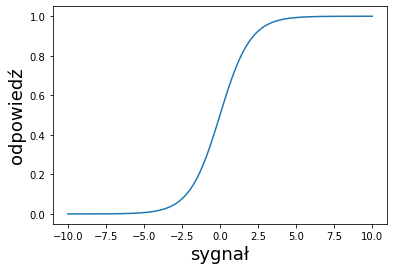

In [ ]:
s = np.linspace(-10, 10, 100)

fs = [sig(z) for z in s]

plt.xlabel('sygnał',fontsize=18)
plt.ylabel('odpowiedź',fontsize=18)

plt.plot(s, fs);

Funkcja ta jest oczywiście różniczkowalna. Co więcej, 

$\sigma'(s)=\sigma(s)[1-\sigma(s)]$,

co jest jej szczególną cechą.

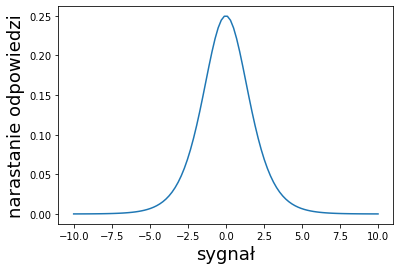

In [ ]:
# pochodna sigmoidu
def dsig(s):
     return sig(s)*(1-sig(s)) # szczególna cecha tej funkcji
    
s = np.linspace(-10, 10, 100)
dfs = [dsig(z) for z in s]

plt.xlabel('sygnał',fontsize=18)
plt.ylabel('narastanie odpowiedzi',fontsize=18)

plt.plot(s, dfs);    

Funkcja propagująca sygnał w przód. Określamy ją z sigmoidem

In [ ]:
def feed_forward_sig(n_war, wagi, x_in):
    """Propagacja sygnału w przód"""
    li_war=len(n_war)
    
    x={} # słownik, który będzie zawierać warości sygnałów we wszystkich warstwach
    x.update({0: np.array(x_in)}) 
    
    for i in range(1,li_war): # pętla po warstwach począwszy od pierwszej po inpucie
        a=np.dot(x[i-1],wagi[i]) # sygnał docierający do warstwy i
        b=[sig(a[q]) for q in range(len(a))] # sygnał wychodzacy z warstwy (określony przez funkcję aktywacji)
        x.update({i: np.insert(b,0,1)}) # dopisanie do słownika po wstawieniu sygnału 1 dla węzła progowego
        
    return x

# Przykład z punktami w kole


In [ ]:
# zwraca losowe współrzędne x1, x2 oraz 1 dla punktów 
# w kole o środku (0.5,0.5) i promeniu 0.4, a 0 poza nim

def kolo():
    x1=random.random()
    x2=random.random()
    if((x1-0.5)*(x1-0.5)+(x2-0.5)*(x2-0.5) < 0.4*0.4): # w kole
        return np.array([x1,x2,1])
    else:                                              # poza kołem
        return np.array([x1,x2,0])


In [ ]:
# nasz punkt i liczba "kontrolna" czy "klasyfikująca":, wskazująca czy jest w okręgu czy poza
kolo()

# format:  x1          x2       l. kontrolna 

array([0.02873765, 0.58567431, 0.        ])

In [ ]:
# losowa próbka szkoleniowa 3000 punktów 
probka_k=np.array([kolo() for i in range(3000)])
da_k=np.delete(probka_k,2,1)
od_k=np.delete(np.delete(probka_k,0,1),0,1)

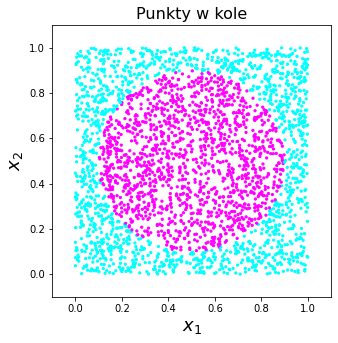

In [ ]:
plt.figure(figsize=(5,5))
plt.title("Punkty w kole",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(probka_k[:,0],probka_k[:,1],c=probka_k[:,2],
            s=5,cmap=mpl.cm.cool,norm=mpl.colors.Normalize(vmin=0, vmax=.9))

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

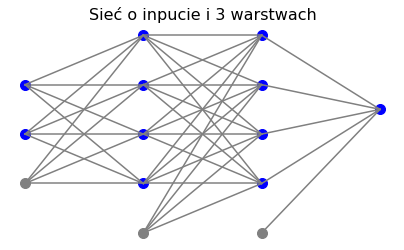

In [ ]:
# sieć o dość pokaźnej liczbie neuronów
siec=[3,5,5,2]
plot_net(siec)

wagi=ran_w_s(siec,5.); # początkowe losowe wagi

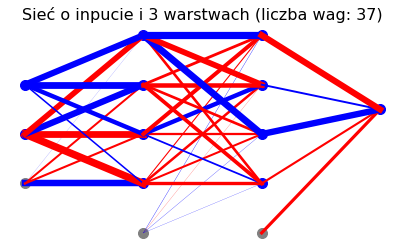

In [ ]:
plot_net_w(siec,wagi)

In [ ]:
# uczenie trwa dość długo, trzeba tę komórkę przepuścić wiele razy

eps=.7

for k in range(500):  # 500 rund
    eps=.99*eps
    if k%10==9:
        print(k+1,' ',end='')
    for p in range(len(probka_k)):
        back_prop(da_k,od_k,p,siec,wagi,eps)

10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  210  220  230  240  250  260  270  280  290  300  310  320  330  340  350  360  370  380  390  400  410  420  430  440  450  460  470  480  490  500  

#### Sprawdzenie na próbce testowej

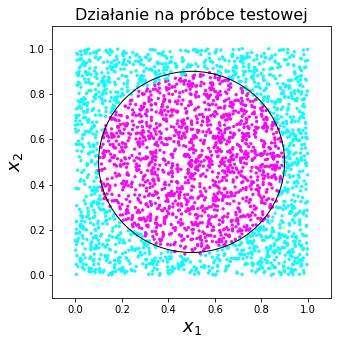

In [ ]:
test=[] # próbka testowa

for k in range(3000):
    po=[1,random.random(),random.random()]  # nowy punkt testowy
    xt=feed_forward_sig(siec,wagi,po)    # generowanie wyniku dla tego punktu
    test.append([po[1],po[2],np.round(xt[3][1],0)]) # zapis do tablicy

tt=np.array(test) # zmiana formatu tablicy na numpy  

fig=plt.figure(figsize=(5,5))

# dorysowanie okręgu
ax=fig.add_subplot(1,1,1)
circ=plt.Circle((0.5,0.5), radius=.4, color='black', fill=False)
ax.add_patch(circ)

plt.title("Działanie na próbce testowej",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(tt[:,0],tt[:,1],c=tt[:,2],
            s=5,cmap=mpl.cm.cool,norm=mpl.colors.Normalize(vmin=0, vmax=.9))

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

Komentarz: Fascynujące jest, że nauczyliśmy sieć rozpoznawać, czy punkt jest w kole, a nie ma ona pojecia o geometrii, odległości euklidesowej, równaniu okregu itd. Po prostu sieć nauczyła się tego "empirycznie".

# To samo ale z użyciem pakietu Scikit Learn https://scikit-learn.org 




# Załączone pakiety

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Przykład z punktami w kole


In [4]:
# zwraca losowe współrzędne x1, x2 oraz 1 dla punktów 
# w kole o środku (0.5,0.5) i promeniu 0.4, a 0 poza nim

def kolo():
    x1=random.random()
    x2=random.random()
    if((x1-0.5)*(x1-0.5)+(x2-0.5)*(x2-0.5) < 0.4*0.4): # w kole
        return np.array([x1,x2,1])
    else:                                              # poza kołem
        return np.array([x1,x2,0])


# `Przygotowanie danych`

In [5]:
probka_k=np.array([kolo() for i in range(6000)])
print(probka_k.shape)

(6000, 3)


# Definiuję funkcję rysującą dane

In [6]:
def draw_result(X,y): 
  fig=plt.figure(figsize=(5,5))

  # dorysowanie okręgu
  #ax=fig.add_subplot(1,1,1)
  #circ=plt.Circle((0.5,0.5), radius=.4, color='black', fill=False)
  #ax.add_patch(circ)

  plt.title("Działanie na próbce testowej",fontsize=16) 
  plt.xlim(min(X[:,0]),max(X[:,0]))
  plt.ylim(min(X[:,1]),max(X[:,1]))
  plt.scatter(X[:,0],X[:,1],c=y,
            s=5,cmap=mpl.cm.cool,norm=mpl.colors.Normalize(vmin=min(y), vmax=max(y)))

  plt.xlabel('$x_1$',fontsize=18)
  plt.ylabel('$x_2$',fontsize=18);

# Przygotowanie formatu danych

Shapes of datasets X_train, X_test, y_train, y_test:  (3000, 2) (3000, 2) (3000,) (3000,)


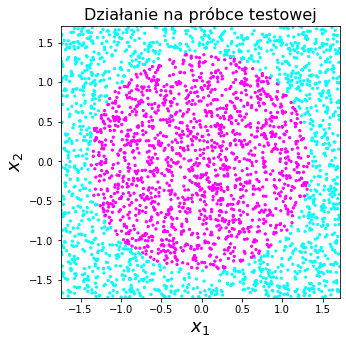

In [7]:

X, y = probka_k[:,:2], probka_k[:,2]

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=42)

print("Shapes of datasets X_train, X_test, y_train, y_test: ",X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#narysuj dane testowe
draw_result(X_test, y_test)

# **Trening** 

Instrukcja użycia Multi Layer Perceptron
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

In [8]:

clf = MLPClassifier(hidden_layer_sizes=(5,5), activation='tanh', alpha=0.1, 
                    learning_rate_init=0.01, early_stopping=True,validation_fraction=0.2,verbose=True,n_iter_no_change=100,max_iter=1000)
                    #max_iter=1000) 


print(clf.fit(X_train, y_train))

# get score
score = clf.score(X_test, y_test)
print("Score = ",score)

# get prediction
Z = clf.predict_proba(X_test)[:,1] # returns probability 
print(Z)

Iteration 1, loss = 0.74924267
Validation score: 0.603333
Iteration 2, loss = 0.67672817
Validation score: 0.671667
Iteration 3, loss = 0.65116029
Validation score: 0.771667
Iteration 4, loss = 0.61209597
Validation score: 0.725000
Iteration 5, loss = 0.56338135
Validation score: 0.846667
Iteration 6, loss = 0.50345373
Validation score: 0.866667
Iteration 7, loss = 0.44254512
Validation score: 0.895000
Iteration 8, loss = 0.38892393
Validation score: 0.906667
Iteration 9, loss = 0.34535052
Validation score: 0.908333
Iteration 10, loss = 0.30857407
Validation score: 0.928333
Iteration 11, loss = 0.27972363
Validation score: 0.928333
Iteration 12, loss = 0.25744721
Validation score: 0.940000
Iteration 13, loss = 0.23702290
Validation score: 0.936667
Iteration 14, loss = 0.22117362
Validation score: 0.941667
Iteration 15, loss = 0.20917567
Validation score: 0.943333
Iteration 16, loss = 0.19693416
Validation score: 0.951667
Iteration 17, loss = 0.18699183
Validation score: 0.950000
Iterat

# Plot training andvalidation loss

[0.6033333333333334, 0.6716666666666666, 0.7716666666666666, 0.725, 0.8466666666666667, 0.8666666666666667, 0.895, 0.9066666666666666, 0.9083333333333333, 0.9283333333333333, 0.9283333333333333, 0.94, 0.9366666666666666, 0.9416666666666667, 0.9433333333333334, 0.9516666666666667, 0.95, 0.955, 0.955, 0.9566666666666667, 0.9566666666666667, 0.9583333333333334, 0.9666666666666667, 0.9633333333333334, 0.97, 0.96, 0.9716666666666667, 0.98, 0.965, 0.9733333333333334, 0.9766666666666667, 0.9766666666666667, 0.98, 0.9683333333333334, 0.975, 0.9666666666666667, 0.985, 0.99, 0.9733333333333334, 0.9716666666666667, 0.9633333333333334, 0.9816666666666667, 0.985, 0.98, 0.975, 0.9883333333333333, 0.9716666666666667, 0.99, 0.9783333333333334, 0.9766666666666667, 0.9716666666666667, 0.985, 0.99, 0.98, 0.9866666666666667, 0.9766666666666667, 0.9816666666666667, 0.9866666666666667, 0.985, 0.9866666666666667, 0.9833333333333333, 0.9883333333333333, 0.9933333333333333, 0.98, 0.9883333333333333, 0.98833333

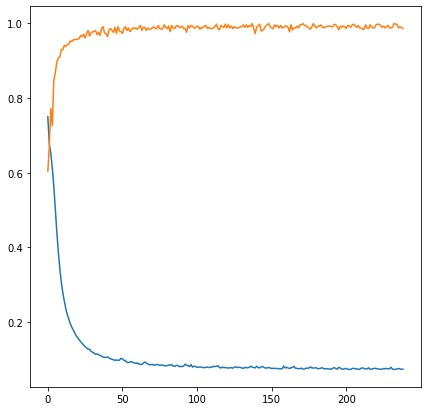

In [9]:
fig=plt.figure(figsize=(7,7))

plt.plot(clf.loss_curve_)
#Warning: thiscan be usedonly if early_stopping=True
print(clf.validation_scores_)
plt.plot(np.asarray(clf.validation_scores_))

plt.show()

#Narysuj dane testowe z prawdopodobieństwem przewidywanym przez sieć neuronową

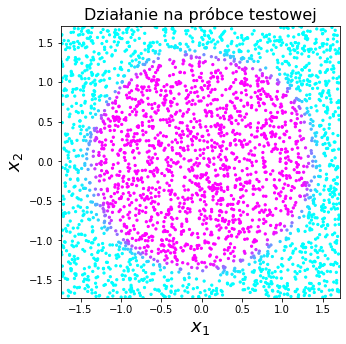

In [10]:
draw_result(X_test, Z)

# **Krzywa ROC**

<Figure size 504x504 with 0 Axes>

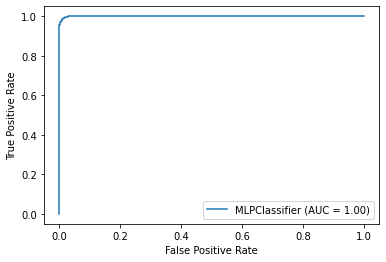

Area Under Curve AUC =  0.9995857628652409
Area Under Curve AUC =  0.9995857628652409


In [11]:
from sklearn.metrics import plot_roc_curve, auc, roc_curve, roc_auc_score

fig=plt.figure(figsize=(7,7))

roc_disp = plot_roc_curve(clf, X_test, y_test)
plt.show()

#Print AUC
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
print("Area Under Curve AUC = ",roc_auc)

#simpler method
print("Area Under Curve AUC = ",roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

# Visualize NN

--2020-11-18 21:27:33--  https://raw.githubusercontent.com/jzliu-100/visualize-neural-network/master/VisualizeNN.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9495 (9.3K) [text/plain]
Saving to: ‘VisualizeNN.py’

VisualizeNN.py      100%[===================>]   9.27K  --.-KB/s    in 0s      

2020-11-18 21:27:33 (96.3 MB/s) - ‘VisualizeNN.py’ saved [9495/9495]



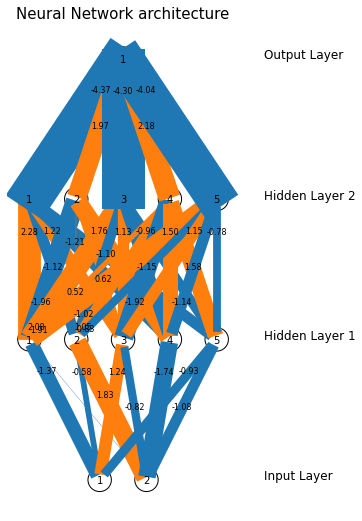

In [12]:
! wget https://raw.githubusercontent.com/jzliu-100/visualize-neural-network/master/VisualizeNN.py

import VisualizeNN as VisNN
'''
print(clf.hidden_layer_sizes[0])
print(clf.n_outputs_)
print(clf.coefs_[0].shape)
print(clf.coefs_[1].shape)
print(clf.coefs_[2].shape)
'''

NN = list(clf.hidden_layer_sizes)
NN.append(clf.n_outputs_)
NN.insert(0,clf.coefs_[0].shape[0])
network=VisNN.DrawNN(NN,clf.coefs_)
network.draw()

# To samo z użyciem drzew decyzyjnych BDT

In [13]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#Drzewo decyzyjne
#clf = DecisionTreeClassifier(max_depth=5)

# Wzmocnione drzewo decyzyjne BDT
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200)


print(clf.fit(X_train, y_train))

# get score
score = clf.score(X_test, y_test)
print("Score = ",score)

# get prediction
Z = clf.predict_proba(X_test)[:,1] # returns probability 
print(Z)


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

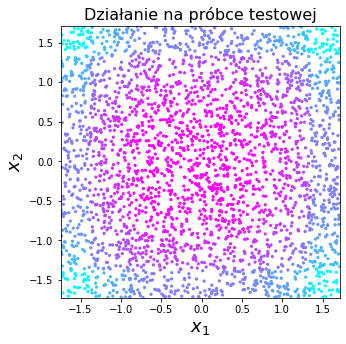

In [14]:
draw_result(X_test,Z)

# **Krzywa ROC**

<Figure size 504x504 with 0 Axes>

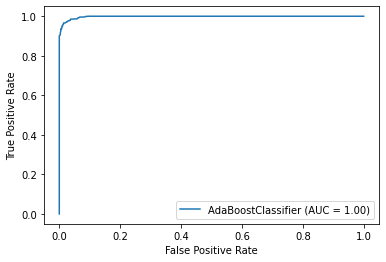

Area Under Curve AUC =  0.9979930388605102
Area Under Curve AUC =  0.9979930388605102


In [15]:
from sklearn.metrics import plot_roc_curve, auc, roc_curve, roc_auc_score

fig=plt.figure(figsize=(7,7))

roc_disp = plot_roc_curve(clf, X_test, y_test)
plt.show()

#Print AUC
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
print("Area Under Curve AUC = ",roc_auc)

#simpler method
print("Area Under Curve AUC = ",roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))